BiLSTM+Attention (提案手法)Yahooニュースで学習し、Yahooニュースの残りとLivedoorの全データでテストする
テストデータに対して分類結果をまとめたjsonファイルを作成

In [48]:
from keras.layers          import Lambda, Input, Dense, GRU, LSTM, Dropout
from keras.models          import Model
from keras.layers.wrappers import Bidirectional
from keras.callbacks       import LambdaCallback 
from keras.optimizers      import Adam
from keras.engine.topology import Layer
from keras.layers.normalization import BatchNormalization as BN
import keras.backend as K
import random
import sys
import pickle
import glob
import copy
import os
import re
import MeCab
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from gensim.models import word2vec
import numpy as np
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import initializers
from sklearn.decomposition import PCA
import json
model = word2vec.Word2Vec.load('/mnt/sdc/wikipedia_data/jawiki_wakati.model')

In [49]:
addDict={}
seq_len=13
categories=6

In [50]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [51]:
def predictVector(word, around_words_list):
    global addDict
    if word in addDict:
        return addDict[word]
    else:
        return addUnknownWord(word,around_words_list)

def addUnknownWord(word , around_words_list):
    global addDict
    rand_vector=np.random.rand(200)/np.linalg.norm(np.random.rand(200))*(10+ 3*np.random.rand(1))
    vector=np.array(model[model.predict_output_word(around_words_list)[0][0]])+rand_vector
    addDict[word]=vector
    return vector
    
def Wakati(text):
    m = MeCab.Tagger ("-Ochasen -d /usr/lib/mecab/dic/mecab-ipadic-neologd -Owakati")
    result=m.parse(text)
    ws = re.compile(" ")
    words = [word for word in ws.split(result)]
    if words[-1] == u"\n":
        words = words[:-1]
    return [word for word in words if word!="「" and word!="」" and word!="、"and word!="。"
            and word!="!" and word!="?"]

def seq2vecs(words,predict):
    global addDict
    vectors=[]
    for i in range(len(words)):
            if (words[i] in addDict) and predict:
                vectors.append(addDict[words[i]])
            else
                try:
                    vectors.append(model[words[i]])
                except:
                    if predict:
                        try:
                            vectors.append(predictVector(words[i],[words[i-1]]))
                        except:
                            if i==0:
                                continue
                            else:
                                similar_word=model.similar_by_vector(addDict[words[i-1]], topn=10, restrict_vocab=None)[0][0]
                                vectors.append(predictVector(words[i],[similar_word]))
                    else:
                        return []
    return vectors
def train_test_divide(X,Y,test_rate):
    datanum=len(X)
    n=math.floor(datanum*test_rate)
    X_train=np.array(X[:datanum-n])
    Y_train=np.array(Y[:datanum-n])
    X_test=np.array(X[datanum-n:])
    Y_test=np.array(Y[datanum-n:])
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    return (X_train,Y_train),(X_test,Y_test)

def onehot_vector(number):
    global categories
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot

def load_file(filename):
    ttl=[]
    cat=[]
    with open(filename, "r") as f:
        lines = [line for line in f]
        for line in lines:
            title,category=line.split(" ")
            ttl.append(title)
            cat.append(int(category))
    ttl,cat=shuffle(ttl,cat)
    ttl=np.array(ttl)
    cat=np.array(cat)
    return ttl,cat
def create_data(ttl,cat,predict,sfl):
    X=[]
    Y=[]
    T=[]
    for i in range(len(ttl)):
        title=ttl[i]
        category=cat[i]
        words=Wakati(title)
        input_vectors=seq2vecs(words,predict)
        if len(input_vectors) > seq_len:
            input_vectors=input_vectors[:seq_len]
        elif len(input_vectors)==0:
            continue
        if sfl:
            random.shuffle(input_vectors)
        x = [ [0.]*200 for _ in range(seq_len) ]
        x[0:len(input_vectors)]=input_vectors
        y=onehot_vector(int(category))
        X.append(np.array(x))
        Y.append(np.array(y))
        T.append(title)
    X=np.array(X)
    Y=np.array(Y)
    return X,Y,T
def load_dataset(filename,sfl):
    global seq_len
    ttl,cat=load_file(filename)
    if filename=="../data/livedoor_data.txt":
        X_test,Y_test,T_test=create_data(ttl,cat,predict=True,sfl=False)
        return X_test,Y_test,T_test
    else:
        (train_ttl,train_cat),(test_ttl,test_cat)=train_test_divide(ttl,cat,0.1)
        X_train,Y_train,T_train=create_data(train_ttl,train_cat,predict=False,sfl=False)
        X_test,Y_test,T_test=create_data(test_ttl,test_cat,predict=True,sfl=False)
        return (X_train,Y_train,T_train),(X_test,Y_test,T_test)
    
(X_train,Y_train,T_train),(X_test,Y_test,T_test)=load_dataset("./data/yahoo_data.txt"
                                                              ,sfl=False)    

In [57]:
Livedoor_X,Livedoor_Y,Livedoor_T=load_dataset("../data/livedoor_data.txt",sfl=False)

(1729,)
(1729,)
file: livedoor


/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/gensim/models/word2vec.py:1463: UserWarning: All the input context words are out-of-vocabulary for the current model.
  warnings.warn("All the input context words are out-of-vocabulary for the current model.")
/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `similar_by_v

-------DataShape------
(1729, 13, 200)
(1729, 6)
1729
-------DataProperties------
max:30
min:4
mean:11.70561017929439


In [58]:
def encode(args):
    x,weights=args
    weighted_input = K.batch_dot(weights, x)
    weighted_input=K.squeeze(weighted_input,axis=1)
    return weighted_input

In [59]:
class AttLayer(Layer):
    
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        self.W = K.variable(self.init((input_shape[-1],1)))
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)

    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x,self.W))
        eij=K.squeeze(eij,axis=2)
        ai = K.exp(eij)
        Sum=K.expand_dims(K.sum(ai, axis=1),axis=1)
        weights = ai/Sum
        weights=K.expand_dims(weights,axis=1)
        return weights

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [64]:
inputs      = Input(shape=(seq_len, 200))
x     = Bidirectional(LSTM(512,return_sequences=True,dropout=0.3))(inputs)
weights    = AttLayer(name="attention")(x)
encoded   = Lambda(encode,output_shape=(1024,),name="encoder")([x,weights])
preds     = Dense(categories,activation='softmax')(encoded)
LSTM_Model = Model(inputs=inputs, outputs=preds)
LSTM_Model.summary()
LSTM_Model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=["accuracy"])
history =LSTM_Model.fit(X_train,Y_train,shuffle=True,batch_size=30,epochs=3,
                   validation_split=0.3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 13, 200)      0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 13, 1024)     2920448     input_5[0][0]                    
__________________________________________________________________________________________________
attention (AttLayer)            (None, 13)           1024        bidirectional_5[0][0]            
__________________________________________________________________________________________________
encoder (Lambda)                (None, 1024)         0           bidirectional_5[0][0]            
                                                                 attention[0][0]                  
__________

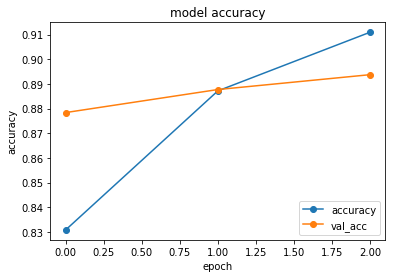

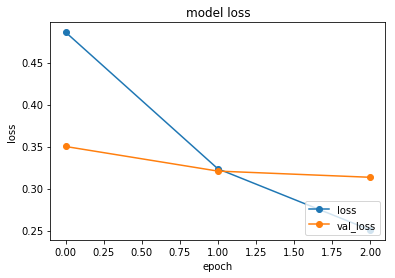

In [65]:
plot_history(history)

In [66]:
LSTM_Model.save('lstm_attention.h5')

In [67]:
loss_and_metrics_yahoo = LSTM_Model.evaluate(X_test,Y_test)
loss_and_metrics_livedoor = LSTM_Model.evaluate(Livedoor_X,Livedoor_Y)
print("\n <Yahoo> loss:{} accuracy:{}"
      .format(loss_and_metrics_yahoo[0],loss_and_metrics_yahoo[1]))
print("\n <Livedoor> loss:{} accuracy:{}"
      .format(loss_and_metrics_livedoor[0],loss_and_metrics_livedoor[1]))

1729/1729 [==============================] - 1s 739us/step

 <Yahoo> loss:0.4507418441863298 accuracy:0.8602214550486575

 <Livedoor> loss:0.7702634943365844 accuracy:0.7790630422209369


結果データの作成

In [68]:
def getAttentionVectors(X):
    layer_name = "attention"
    attention_layer_model = Model(inputs=LSTM_Model.input,
                                 outputs=LSTM_Model.get_layer(layer_name).output)
    attention_output = attention_layer_model.predict(X)
    attention_vectors=attention_output.reshape(attention_output.shape[0],
                                               attention_output.shape[-1])
    return attention_vectors

In [69]:
def getEncodedVectors(X):
    layer_name = 'encoder'
    encoder_layer_model = Model(inputs=LSTM_Model.input,
                                 outputs=LSTM_Model.get_layer(layer_name).output)
    encoded_vectors = encoder_layer_model.predict(X)
    pca = PCA()
    pca.fit(encoded_vectors)
    pca_results = pca.fit_transform(encoded_vectors)[:,:3]
    return encoded_vectors,pca_results

In [70]:
def getProperties(X,Y):
    correct_wrong=[]
    answer_category=[]
    outputs=LSTM_Model.predict(X)
    for i in range(len(outputs)):
        answer_category.append(int(outputs[i].argmax()))
        if int(outputs[i].argmax())==int(Y[i].argmax()):
            correct_wrong.append(1)
        else:
            correct_wrong.append(0)
    return correct_wrong,answer_category

In [71]:
def create_json(X,Y,T,savepath):
    attention_vectors=getAttentionVectors(X)
    encoded_vectors,pca_results=getEncodedVectors(X)
    correct_wrong,answer_category=getProperties(X,Y)
    dic={}
    dic["result"]=[]
    for i in range(len(X)):
        inner_dic={}
        inner_dic["id"]=i
        inner_dic["title"]=T[i]
        inner_dic["category_num"]=list(Y[i]).index(1)
        inner_dic["output_category_num"]=answer_category[i]
        inner_dic["encoded_vector"]=list(map(float,encoded_vectors[i]))
        inner_dic["pca_result"]=list(map(float,pca_results[i]))
        inner_dic["correct"]=correct_wrong[i]
        inner_dic["attention"]=list(map(float,attention_vectors[i]))
        dic["result"].append(inner_dic)
    with open(savepath, 'w') as outfile:
        json.dump(dic, outfile)

In [72]:
create_json(X_test,Y_test,T_test,"yahoo.json")
create_json(Livedoor_X,Livedoor_Y,Livedoor_T,"livedoor.json")

(8399, 13)
(8399, 1024)
(8399, 3)
(1729, 13)
(1729, 1024)
(1729, 3)
